In [1]:
import torch
from torch import nn, optim
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define a network:

class simpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
    
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc  = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hs):
        
        # forward pass thru RNN layer
        rnn_out, hidden = self.rnn(x, hs)
        
        # reshape RNN output for input to FC layer
        rnn_out = rnn_out.view(-1, self.hidden_size)
        
        # forward pass thru FC layer
        output = self.fc(rnn_out)
        
        # return prediction and updated hidden state
        return output, hidden

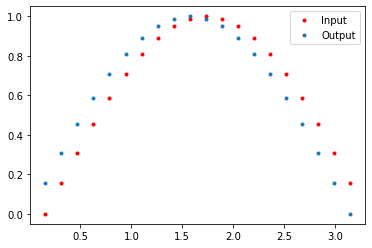

In [3]:
# Create sample data:
seq_len = 20

time = np.linspace(0, np.pi, seq_len + 1)
data = np.sin(time)

x = data[:-1]
y = data[1:]

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

plt.plot(time[1:], x, 'r.', label='Input')
plt.plot(time[1:], y, '.', label='Output')
plt.legend();

In [4]:
# add batch_size and input_size (number of features) dimensions
x = x.unsqueeze(0).unsqueeze(-1) 

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_size  = 1
hidden_size = 32
num_layers  = 1
output_size = 1

rnn = simpleRNN(input_size, hidden_size, num_layers, output_size)    
rnn = rnn.to(device)

# test feedforward: 
output, hidden = rnn(x, None)
print(f'input shape:\t {x.shape}')           # (batch_size, seq_len, num_features)
print(f'hidden shape:\t {hidden.shape}')     # (batch_size, num_layers*num_directions, hidden_size)
print(f'output shape:\t {output.shape}')     # (seq_len, batch_size, num_directions*hidden_size)

input shape:	 torch.Size([1, 20, 1])
hidden shape:	 torch.Size([2, 1, 32])
output shape:	 torch.Size([20, 1])


In [6]:
def train(model, time, x_train, y_train, steps, show=25):
    
    criterion = nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    hs = None
    
    for step in range(steps):
        
        opt.zero_grad()
        y_hat, hs = model(x_train, hs)
        loss = criterion(y_hat.squeeze(), y_train)
        
        hs = hs.data
        
        loss.backward()
        opt.step()
        
        if step % show == 0:
        
            plt.plot(time, x.squeeze(), 'b.', label='Input')
            plt.plot(time, y_hat.detach(), 'r.', label='Prediction')
            plt.legend()
            plt.show()
    
    return model

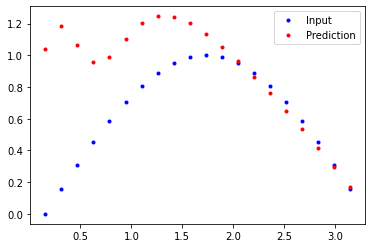

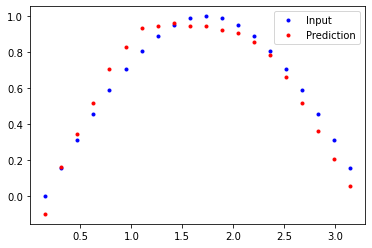

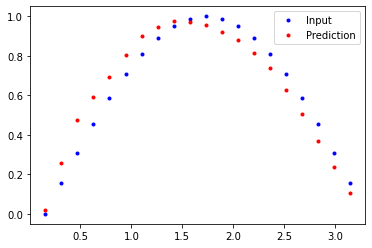

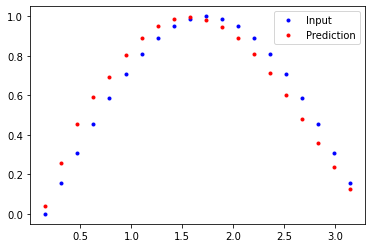

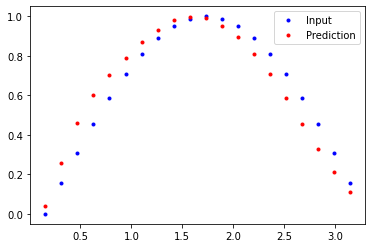

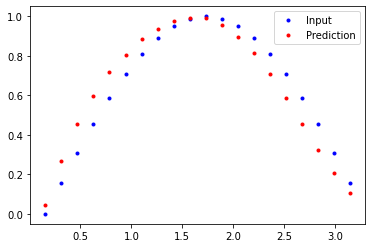

In [8]:
x = x.to(device)
y = y.to(device)

rnn = train(rnn, time[1:], x, y, 150)        